# Molecular Diffusion with Graph Neural Networks: A DeepChem Tutorial

This notebook demonstrates how to implement molecular diffusion models using Graph Neural Networks (GNNs) with DeepChem data. We'll explore the fundamentals of denoising diffusion probabilistic models (DDPMs) applied to molecular generation.

## Key Concepts:
- **DDPM**: Gradually adds noise to data, then learns to reverse the process
- **GNN Integration**: Uses graph structure of molecules for better representations
- **Molecular Generation**: Creates new drug-like molecules from learned distributions

In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import warnings
import time
from collections import defaultdict
import seaborn as sns

warnings.filterwarnings('ignore')

from diffusion_gnn.data.deepchem import DeepChemMolecularDataset
from diffusion_gnn.models import (
    create_diffusion_model,
    create_molecular_gnn,
    create_noise_scheduler,
    count_parameters,
    MolecularPropertyPredictor
)
from diffusion_gnn.utils.mol_diff_gnn import (
    visualize_molecule,
    plot_training_metrics,
    plot_molecular_properties,
    calculate_molecular_diversity
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Dataset Exploration

In [23]:
# Start with small molecules first
dataset = DeepChemMolecularDataset('tox21', max_atoms=30)

print(f"Dataset: {dataset.dataset_name}")
print(f"Number of molecules: {len(dataset.dataset)}")
print(f"Max atoms allowed: {dataset.max_atoms}")
print(f"Atom feature dimension: {dataset._get_atom_feature_dim()}")
print(f"Bond feature dimension: {dataset._get_bond_feature_dim()}")


INFO:diffusion_gnn.data.deepchem:Loading DeepChem dataset: tox21
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:deepchem.data.datasets:Loading dataset from disk.
INFO:diffusion_gnn.data.deepchem:Loaded tox21 dataset with 6258 molecules


Dataset: tox21
Number of molecules: 6258
Max atoms allowed: 30
Atom feature dimension: 37
Bond feature dimension: 10


In [24]:
# Let's examine some raw SMILES from the dataset
sample_smiles = []
for i in range(10):
    smiles = dataset.dataset.ids[i]
    sample_smiles.append(smiles)
    print(f"{i+1:2d}: {smiles}")

 1: CC(O)(P(=O)(O)O)P(=O)(O)O
 2: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
 3: OC[C@H](O)[C@@H](O)[C@H](O)CO
 4: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
 5: CC(C)COC(=O)C(C)C
 6: C=C(C)C(=O)OCCOC(=O)C(=C)C
 7: CCCCCCCCCCOCC(O)CN
 8: C#CCO
 9: CC(O)CC(C)(C)O
10: CC(C)(C)CC(C)(C)N


# Molecular Property Analysis

In [25]:
# Analyze molecular properties
def analyze_molecules(smiles_list, max_analyze=1000):
    """Analyze basic molecular properties"""
    properties = {
        'num_atoms': [],
        'num_bonds': [],
        'molecular_weight': [],
        'logp': [],
        'num_rings': [],
        'smiles': []
    }

    valid_count = 0
    for smiles in smiles_list[:max_analyze]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            properties['num_atoms'].append(mol.GetNumAtoms())
            properties['num_bonds'].append(mol.GetNumBonds())
            properties['molecular_weight'].append(Descriptors.MolWt(mol))
            properties['logp'].append(Descriptors.MolLogP(mol))
            properties['num_rings'].append(Descriptors.RingCount(mol))
            properties['smiles'].append(smiles)
            valid_count += 1

    print(f"Analyzed {valid_count} valid molecules out of {len(smiles_list[:max_analyze])}")
    return pd.DataFrame(properties)


In [26]:
# Analyze the dataset
all_smiles = [dataset.dataset.ids[i] for i in range(len(dataset.dataset))]
mol_df = analyze_molecules(all_smiles, max_analyze=2000)

# Display basic statistics
print("\nMolecular Property Statistics:")
print(mol_df.describe())

[15:53:26] WARNING: not removing hydrogen atom without neighbors


Analyzed 2000 valid molecules out of 2000

Molecular Property Statistics:
         num_atoms    num_bonds  molecular_weight         logp   num_rings
count  2000.000000  2000.000000       2000.000000  2000.000000  2000.00000
mean     11.798000    10.870500        189.812914     1.765332     0.11250
std       6.669215     6.693066        100.286992     2.394732     0.31606
min       1.000000     0.000000          9.012000   -10.036400     0.00000
25%       7.000000     6.000000        122.155250     0.379030     0.00000
50%      10.000000    10.000000        164.831000     1.567650     0.00000
75%      14.000000    13.000000        229.120500     2.956775     0.00000
max      57.000000    56.000000        807.339000    16.428500     1.00000


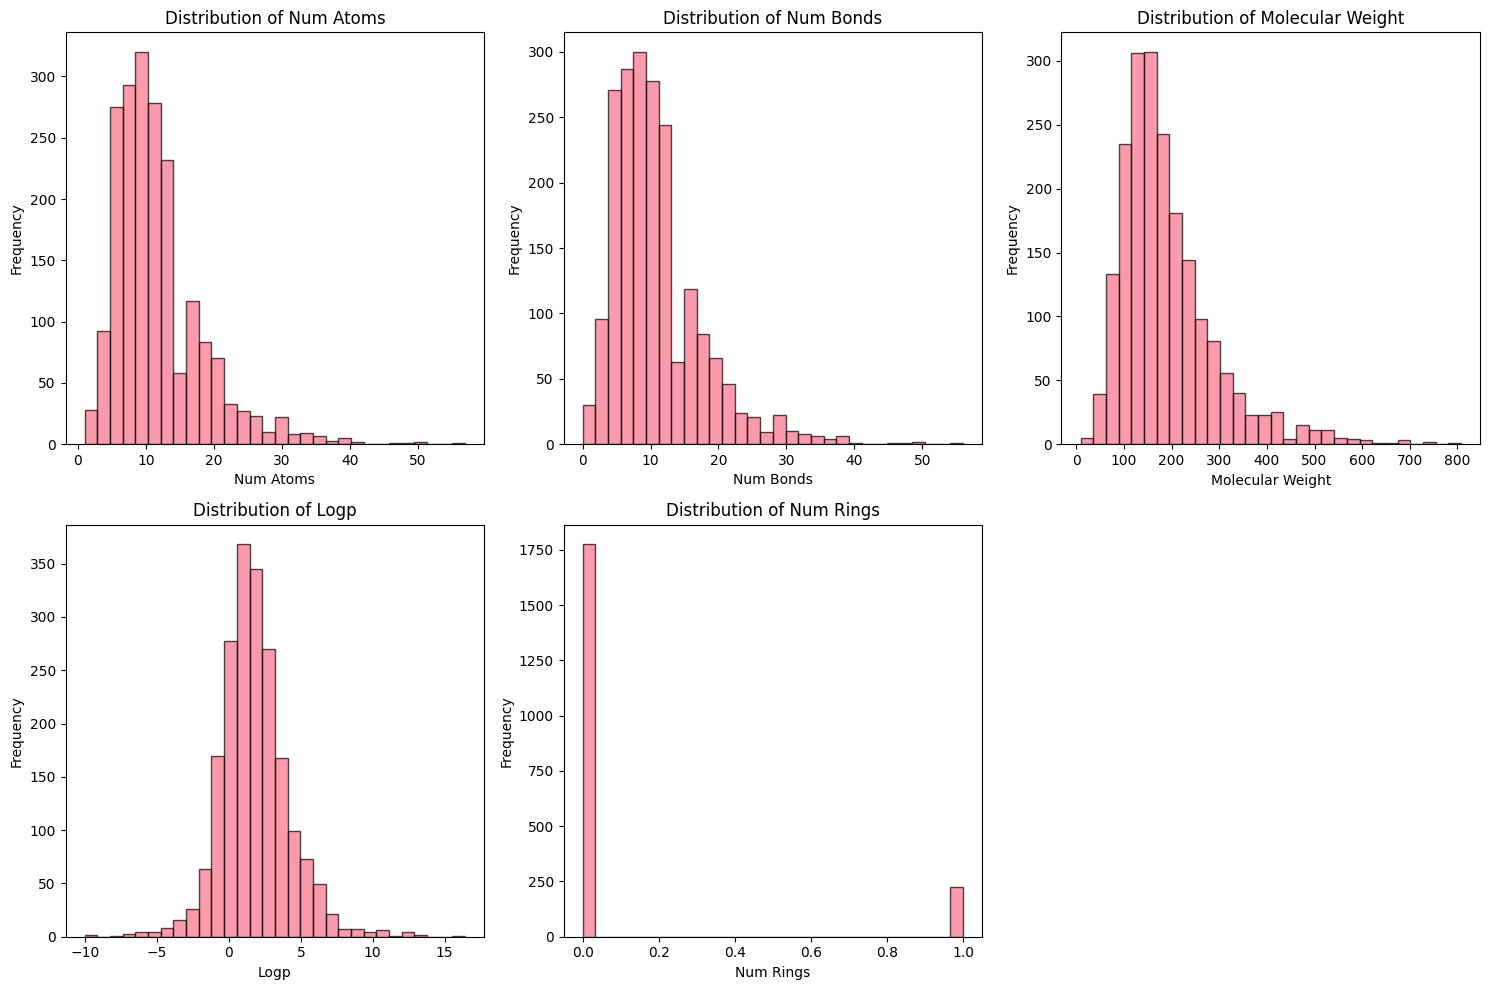

In [27]:
# Visualize molecular property distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

properties = ['num_atoms', 'num_bonds', 'molecular_weight', 'logp', 'num_rings']
for i, prop in enumerate(properties):
    axes[i].hist(mol_df[prop], bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {prop.replace("_", " ").title()}')
    axes[i].set_xlabel(prop.replace("_", " ").title())
    axes[i].set_ylabel('Frequency')

# Remove empty subplot
axes[-1].remove()
plt.tight_layout()
plt.show()

# Graph Conversion and Feature Analysis

In [28]:
# Convert sample molecules to graphs and analyze
sample_graphs = []
conversion_stats = {'successful': 0, 'failed': 0, 'too_large': 0}

print("Converting molecules to graphs...")
for i, smiles in enumerate(sample_smiles[:20]):  # First 20 for detailed analysis
    graph = dataset.smiles_to_graph(smiles)
    if graph is not None:
        sample_graphs.append(graph)
        conversion_stats['successful'] += 1
        print(f"✓ {i+1:2d}: {smiles[:50]:<50} -> {graph.x.shape[0]:2d} atoms, {graph.edge_index.shape[1]:2d} edges")
    else:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None and mol.GetNumAtoms() > dataset.max_atoms:
            conversion_stats['too_large'] += 1
            print(f"✗ {i+1:2d}: {smiles[:50]:<50} -> Too large ({mol.GetNumAtoms()} atoms)")
        else:
            conversion_stats['failed'] += 1
            print(f"✗ {i+1:2d}: {smiles[:50]:<50} -> Conversion failed")

print(f"\nConversion Statistics: {conversion_stats}")

Converting molecules to graphs...
✓  1: CC(O)(P(=O)(O)O)P(=O)(O)O                          -> 11 atoms, 20 edges
✓  2: CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C               -> 20 atoms, 38 edges
✓  3: OC[C@H](O)[C@@H](O)[C@H](O)CO                      -> 10 atoms, 18 edges
✓  4: CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]           -> 21 atoms, 36 edges
✓  5: CC(C)COC(=O)C(C)C                                  -> 10 atoms, 18 edges
✓  6: C=C(C)C(=O)OCCOC(=O)C(=C)C                         -> 14 atoms, 26 edges
✓  7: CCCCCCCCCCOCC(O)CN                                 -> 16 atoms, 30 edges
✓  8: C#CCO                                              ->  4 atoms,  6 edges
✓  9: CC(O)CC(C)(C)O                                     ->  8 atoms, 14 edges
✓ 10: CC(C)(C)CC(C)(C)N                                  ->  9 atoms, 16 edges

Conversion Statistics: {'successful': 10, 'failed': 0, 'too_large': 0}


In [29]:
def analyze_graph_features_simple(graphs):
    """Analyze features using only PyTorch operations"""
    graph_sizes = []
    all_atom_features = []
    all_bond_features = []

    for graph in graphs:
        graph_sizes.append(graph.x.shape[0])
        all_atom_features.append(graph.x)
        if graph.edge_attr.shape[0] > 0:
            all_bond_features.append(graph.edge_attr)

    # Concatenate all features
    atom_features = torch.cat(all_atom_features, dim=0)
    bond_features = torch.cat(all_bond_features, dim=0) if all_bond_features else torch.empty(0, 0)

    return {
        'atom_features': atom_features,
        'bond_features': bond_features,
        'graph_sizes': graph_sizes
    }

# Use the simplified version
feature_stats = analyze_graph_features_simple(sample_graphs)

print(f"Atom features shape: {feature_stats['atom_features'].shape}")
print(f"Bond features shape: {feature_stats['bond_features'].shape}")
print(f"Graph sizes: min={min(feature_stats['graph_sizes'])}, max={max(feature_stats['graph_sizes'])}, avg={sum(feature_stats['graph_sizes'])/len(feature_stats['graph_sizes']):.1f}")

Atom features shape: torch.Size([123, 37])
Bond features shape: torch.Size([222, 10])
Graph sizes: min=4, max=21, avg=12.3


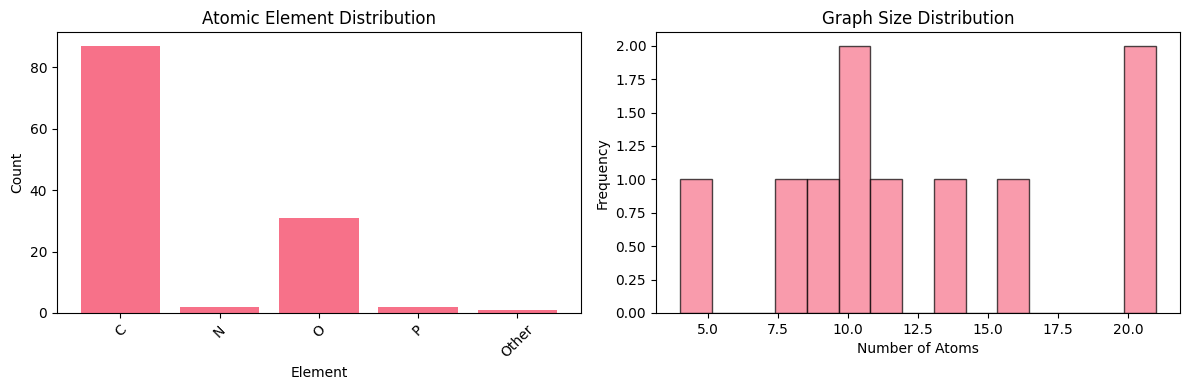

In [30]:
# Visualize feature distributions using PyTorch operations only
if feature_stats['atom_features'].numel() > 0:
    atom_features = feature_stats['atom_features']

    # Atomic number distribution (first 11 features are one-hot encoded atomic numbers)
    # Use PyTorch argmax instead of numpy
    atomic_nums = torch.argmax(atom_features[:, :11], dim=1)
    atomic_elements = ['H', 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'Other']

    # Count occurrences using PyTorch
    unique_nums, counts = torch.unique(atomic_nums, return_counts=True)

    # Convert to Python lists for plotting
    unique_list = unique_nums.tolist()
    counts_list = counts.tolist()
    element_labels = [atomic_elements[i] for i in unique_list]

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.bar(element_labels, counts_list)
    plt.title('Atomic Element Distribution')
    plt.xlabel('Element')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(feature_stats['graph_sizes'], bins=15, alpha=0.7, edgecolor='black')
    plt.title('Graph Size Distribution')
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Molecular Visualisation

Sample molecules from the dataset:


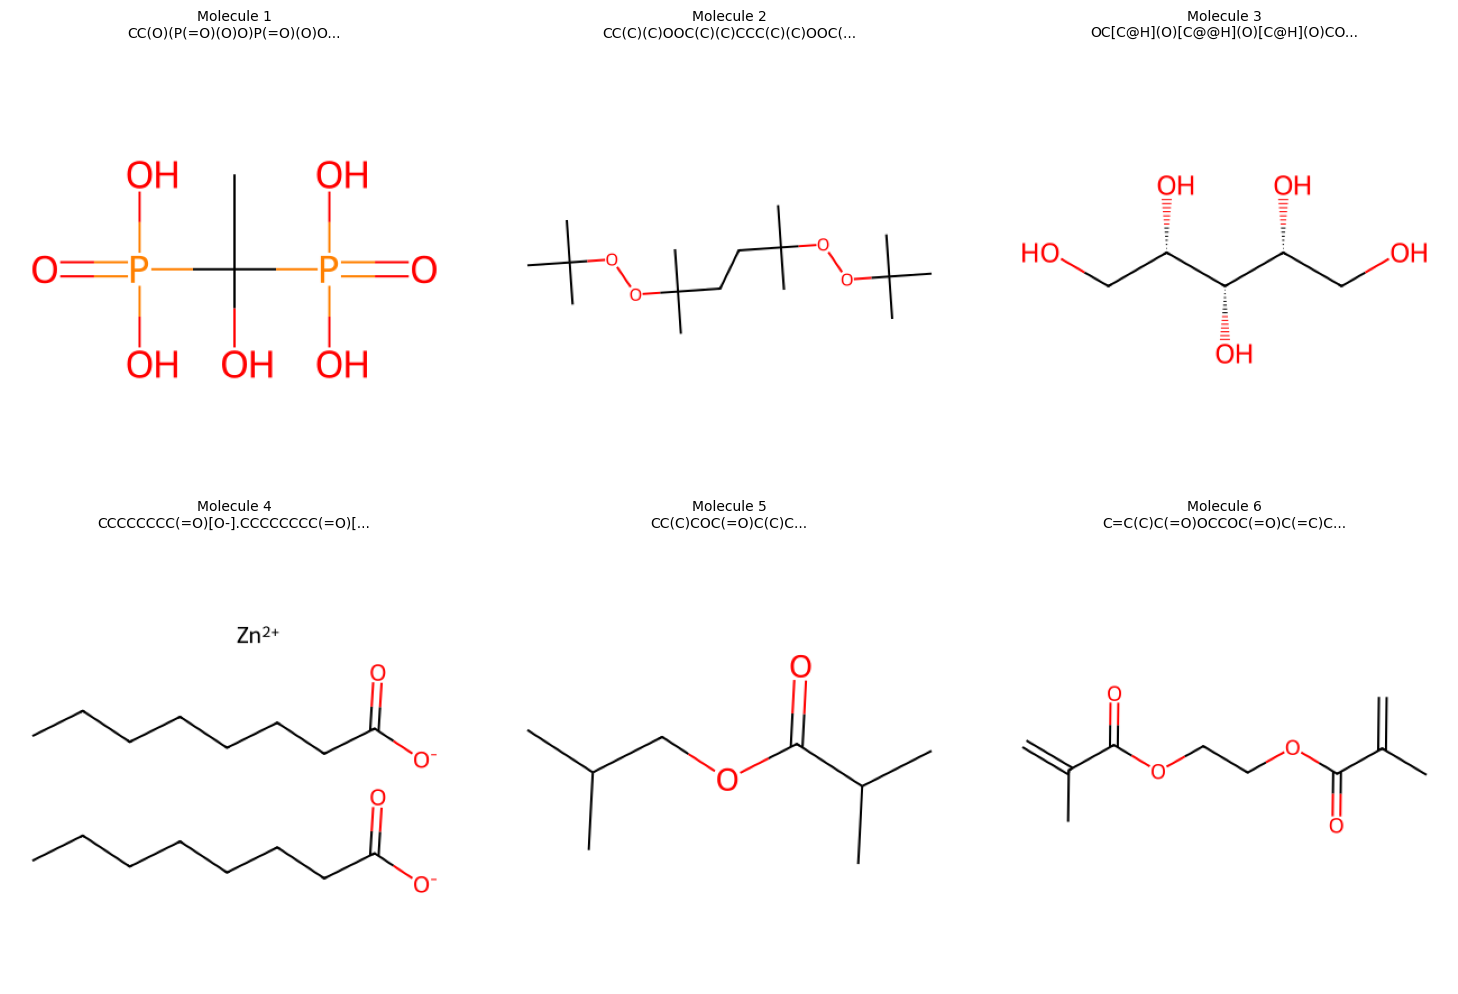

In [31]:
def visualize_sample_molecules(smiles_list, num_samples=6):
    """Visualize sample molecules from SMILES"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(min(num_samples, len(smiles_list))):
        mol = Chem.MolFromSmiles(smiles_list[i])
        if mol is not None:
            img = Draw.MolToImage(mol, size=(400, 400))
            axes[i].imshow(img)
            axes[i].set_title(f'Molecule {i+1}\n{smiles_list[i][:30]}...', fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].text(0.5, 0.5, 'Invalid\nSMILES', ha='center', va='center',
                        transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'Molecule {i+1} (Invalid)')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample molecules
print("Sample molecules from the dataset:")
visualize_sample_molecules(sample_smiles[:6])


# DataLoader Testing

In [ ]:
# Create and test dataloader
print("Creating DataLoader...")
dataloader = dataset.create_dataloader(batch_size=8, shuffle=True)

# Test the dataloader
print("\nTesting DataLoader:")
for i, batch in enumerate(dataloader):
    batch_size = batch.batch.max().item() + 1
    print(f"Batch {i+1}:")
    print(f"  - Batch size: {batch_size}")
    print(f"  - Total nodes: {batch.x.shape[0]}")
    print(f"  - Node features: {batch.x.shape}")
    print(f"  - Edge indices: {batch.edge_index.shape}")
    print(f"  - Edge features: {batch.edge_attr.shape}")
    print(f"  - Average nodes per graph: {batch.x.shape[0] / batch_size:.1f}")

    if i >= 2:  # Only show first 3 batches
        break

INFO:diffusion_gnn.data.deepchem:Converting 6258 molecules to graphs...
INFO:diffusion_gnn.data.deepchem:Processed 0/6258 molecules...


Creating DataLoader...


[15:53:28] WARNING: not removing hydrogen atom without neighbors
INFO:diffusion_gnn.data.deepchem:Processed 1000/6258 molecules...


# Feature Quality Assessment

In [12]:
# Check feature quality and identify potential issues
def assess_feature_quality(dataloader, num_batches=5):
    """Assess the quality of extracted features"""
    stats = {
        'total_graphs': 0,
        'total_nodes': 0,
        'total_edges': 0,
        'nan_features': 0,
        'inf_features': 0,
        'zero_degree_nodes': 0,
        'isolated_graphs': 0
    }

    node_features_all = []
    edge_features_all = []

    for i, batch in enumerate(dataloader):
        if i >= num_batches:
            break

        batch_size = batch.batch.max().item() + 1
        stats['total_graphs'] += batch_size
        stats['total_nodes'] += batch.x.shape[0]
        stats['total_edges'] += batch.edge_index.shape[1]

        # Check for NaN or Inf values
        stats['nan_features'] += torch.isnan(batch.x).sum().item()
        stats['inf_features'] += torch.isinf(batch.x).sum().item()

        # Check for isolated nodes (degree 0)
        degrees = torch.bincount(batch.edge_index[0], minlength=batch.x.shape[0])
        stats['zero_degree_nodes'] += (degrees == 0).sum().item()

        # Check for isolated graphs (no edges)
        if batch.edge_index.shape[1] == 0:
            stats['isolated_graphs'] += batch_size

        node_features_all.append(batch.x)
        edge_features_all.append(batch.edge_attr)

    # Compute feature statistics
    all_node_features = torch.cat(node_features_all, dim=0)
    all_edge_features = torch.cat(edge_features_all, dim=0)

    print("Feature Quality Assessment:")
    print(f"  - Total graphs analyzed: {stats['total_graphs']}")
    print(f"  - Average nodes per graph: {stats['total_nodes'] / stats['total_graphs']:.2f}")
    print(f"  - Average edges per graph: {stats['total_edges'] / stats['total_graphs']:.2f}")
    print(f"  - NaN features: {stats['nan_features']}")
    print(f"  - Inf features: {stats['inf_features']}")
    print(f"  - Zero-degree nodes: {stats['zero_degree_nodes']}")
    print(f"  - Isolated graphs: {stats['isolated_graphs']}")

    print(f"\nNode feature statistics:")
    print(f"  - Min: {all_node_features.min().item():.4f}")
    print(f"  - Max: {all_node_features.max().item():.4f}")
    print(f"  - Mean: {all_node_features.mean().item():.4f}")
    print(f"  - Std: {all_node_features.std().item():.4f}")

    if all_edge_features.numel() > 0:
        print(f"\nEdge feature statistics:")
        print(f"  - Min: {all_edge_features.min().item():.4f}")
        print(f"  - Max: {all_edge_features.max().item():.4f}")
        print(f"  - Mean: {all_edge_features.mean().item():.4f}")
        print(f"  - Std: {all_edge_features.std().item():.4f}")

assess_feature_quality(dataloader)

Feature Quality Assessment:
  - Total graphs analyzed: 40
  - Average nodes per graph: 14.28
  - Average edges per graph: 28.90
  - NaN features: 0
  - Inf features: 0
  - Zero-degree nodes: 0
  - Isolated graphs: 0

Node feature statistics:
  - Min: 0.0000
  - Max: 1.0000
  - Mean: 0.1462
  - Std: 0.3533

Edge feature statistics:
  - Min: 0.0000
  - Max: 1.0000
  - Mean: 0.3005
  - Std: 0.4585


## Comparing Different GNN Architectures

Let's test different GNN types to understand their impact on molecular diffusion:
- **GAT**: Good for complex molecules with diverse bonding patterns
- **GCN**: Efficient for large datasets, simple baseline
- **GIN**: Most expressive for graph structure learning
-

In [13]:
# Get feature dimensions
atom_dim = dataset._get_atom_feature_dim()
bond_dim = dataset._get_bond_feature_dim()

print(f"Atom feature dim: {atom_dim}")
print(f"Bond feature dim: {bond_dim}")

Atom feature dim: 37
Bond feature dim: 10


Comparing GNN Architectures...

Testing GAT...
  Average forward time: 0.0031s
  Average loss: 1.0091
  Parameters: 55,845

Testing GCN...
  Average forward time: 0.0017s
  Average loss: 1.0203
  Parameters: 47,269

Testing GIN...
  Average forward time: 0.0014s
  Average loss: 0.9919
  Parameters: 55,589


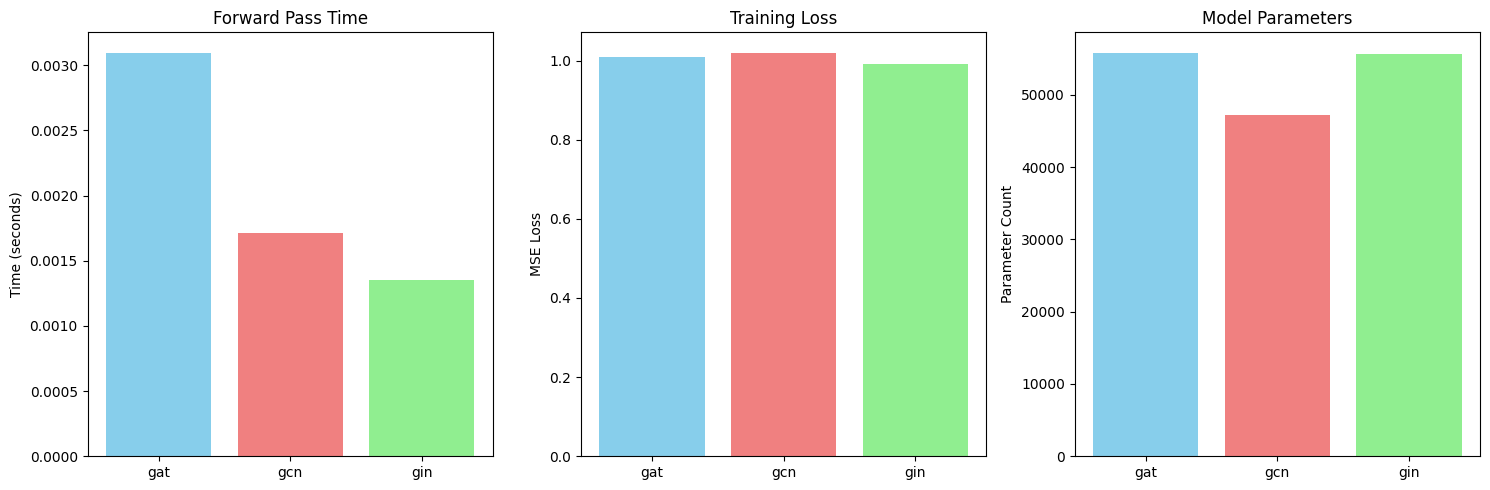

In [14]:
def compare_gnn_architectures(dataloader, atom_dim, bond_dim, device):
    """Compare different GNN architectures for molecular diffusion"""
    gnn_types = ['gat', 'gcn', 'gin']
    results = {}

    print("Comparing GNN Architectures...")
    print("=" * 50)

    for gnn_type in gnn_types:
        print(f"\nTesting {gnn_type.upper()}...")

        # Create model using new factory function
        model = create_diffusion_model(
            atom_dim=atom_dim,
            bond_dim=bond_dim,
            hidden_dim=64,
            num_layers=2,
            gnn_type=gnn_type
        ).to(device)

        # Create noise scheduler
        scheduler = create_noise_scheduler(num_timesteps=100).to(device)

        # Test forward pass and measure time
        model.eval()
        times = []
        losses = []

        with torch.no_grad():
            for i, batch in enumerate(dataloader):
                if i >= 5:  # Test on 5 batches
                    break

                batch = batch.to(device)
                batch_size = batch.batch.max().item() + 1

                # Time forward pass
                start_time = time.time()

                # Sample random timesteps and add noise
                t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
                noise = torch.randn_like(batch.x)
                x_noisy = scheduler.add_noise(batch.x, t[batch.batch], noise)

                # Predict noise
                noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)
                loss = torch.nn.functional.mse_loss(noise_pred, noise)

                end_time = time.time()

                times.append(end_time - start_time)
                losses.append(loss.item())

        # Store results
        results[gnn_type] = {
            'avg_time': np.mean(times),
            'avg_loss': np.mean(losses),
            'params': count_parameters(model),
            'model': model,
            'scheduler': scheduler
        }

        print(f"  Average forward time: {np.mean(times):.4f}s")
        print(f"  Average loss: {np.mean(losses):.4f}")
        print(f"  Parameters: {results[gnn_type]['params']:,}")

    return results

# Compare architectures
atom_dim = dataset._get_atom_feature_dim()
bond_dim = dataset._get_bond_feature_dim()
architecture_results = compare_gnn_architectures(dataloader, atom_dim, bond_dim, device)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

gnn_types = list(architecture_results.keys())
times = [architecture_results[gnn]['avg_time'] for gnn in gnn_types]
losses = [architecture_results[gnn]['avg_loss'] for gnn in gnn_types]
params = [architecture_results[gnn]['params'] for gnn in gnn_types]

axes[0].bar(gnn_types, times, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Forward Pass Time')
axes[0].set_ylabel('Time (seconds)')

axes[1].bar(gnn_types, losses, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Training Loss')
axes[1].set_ylabel('MSE Loss')

axes[2].bar(gnn_types, params, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[2].set_title('Model Parameters')
axes[2].set_ylabel('Parameter Count')

plt.tight_layout()
plt.show()

## Training the Molecular Diffusion Model

Now let's train a complete model with proper logging and validation.

In [15]:
def train_molecular_diffusion(model, scheduler, dataloader, num_epochs=20, lr=1e-3, device='cuda'):
    """Complete training loop with metrics tracking"""

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Metrics tracking
    metrics = {
        'train_loss': [],
        'learning_rate': [],
        'epoch_time': []
    }

    model.train()
    print("Starting training...")
    print("=" * 60)

    for epoch in range(num_epochs):
        epoch_start = time.time()
        epoch_losses = []

        for batch_idx, batch in enumerate(dataloader):
            batch = batch.to(device)
            batch_size = batch.batch.max().item() + 1

            # Forward pass
            optimizer.zero_grad()

            # Sample random timesteps and add noise (DDPM training)
            t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
            noise = torch.randn_like(batch.x)
            x_noisy = scheduler.add_noise(batch.x, t[batch.batch], noise)

            # Predict noise
            noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_losses.append(loss.item())

            # Log progress
            if batch_idx % 20 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.6f}")

        # Update scheduler
        lr_scheduler.step()

        # Record metrics
        epoch_time = time.time() - epoch_start
        avg_loss = np.mean(epoch_losses)
        current_lr = lr_scheduler.get_last_lr()[0]

        metrics['train_loss'].append(avg_loss)
        metrics['learning_rate'].append(current_lr)
        metrics['epoch_time'].append(epoch_time)

        print(f"Epoch {epoch+1} completed - Loss: {avg_loss:.6f}, Time: {epoch_time:.2f}s, LR: {current_lr:.2e}")
        print("-" * 60)

    return metrics


# Select best architecture from comparison (let's use GAT)
best_model = create_diffusion_model(
    atom_dim=atom_dim,
    bond_dim=bond_dim,
    hidden_dim=128,  # Larger for actual training
    num_layers=3,
    gnn_type='gat'  # Best from comparison
).to(device)

# Create noise scheduler for training
noise_scheduler = create_noise_scheduler(num_timesteps=200).to(device)

print(f"Training model with {count_parameters(best_model):,} parameters")

# Train the model
training_metrics = train_molecular_diffusion(
    best_model,
    noise_scheduler,
    dataloader,
    num_epochs=15,
    lr=1e-3,
    device=device
)

Training model with 227,109 parameters
Starting training...
Epoch 1/15, Batch 0, Loss: 1.006959
Epoch 1/15, Batch 20, Loss: 0.985959
Epoch 1/15, Batch 40, Loss: 0.844976
Epoch 1/15, Batch 60, Loss: 0.717029
Epoch 1/15, Batch 80, Loss: 0.705388
Epoch 1/15, Batch 100, Loss: 0.651416
Epoch 1/15, Batch 120, Loss: 0.728064
Epoch 1/15, Batch 140, Loss: 0.578548
Epoch 1/15, Batch 160, Loss: 0.524558
Epoch 1/15, Batch 180, Loss: 0.613077
Epoch 1/15, Batch 200, Loss: 0.567858
Epoch 1/15, Batch 220, Loss: 0.448718
Epoch 1/15, Batch 240, Loss: 0.478849
Epoch 1/15, Batch 260, Loss: 0.429411
Epoch 1/15, Batch 280, Loss: 0.309960
Epoch 1/15, Batch 300, Loss: 0.352375
Epoch 1/15, Batch 320, Loss: 0.380572
Epoch 1/15, Batch 340, Loss: 0.398619
Epoch 1/15, Batch 360, Loss: 0.288746
Epoch 1/15, Batch 380, Loss: 0.407279
Epoch 1/15, Batch 400, Loss: 0.281845
Epoch 1/15, Batch 420, Loss: 0.394536
Epoch 1/15, Batch 440, Loss: 0.548603
Epoch 1/15, Batch 460, Loss: 0.242901
Epoch 1/15, Batch 480, Loss: 0.243

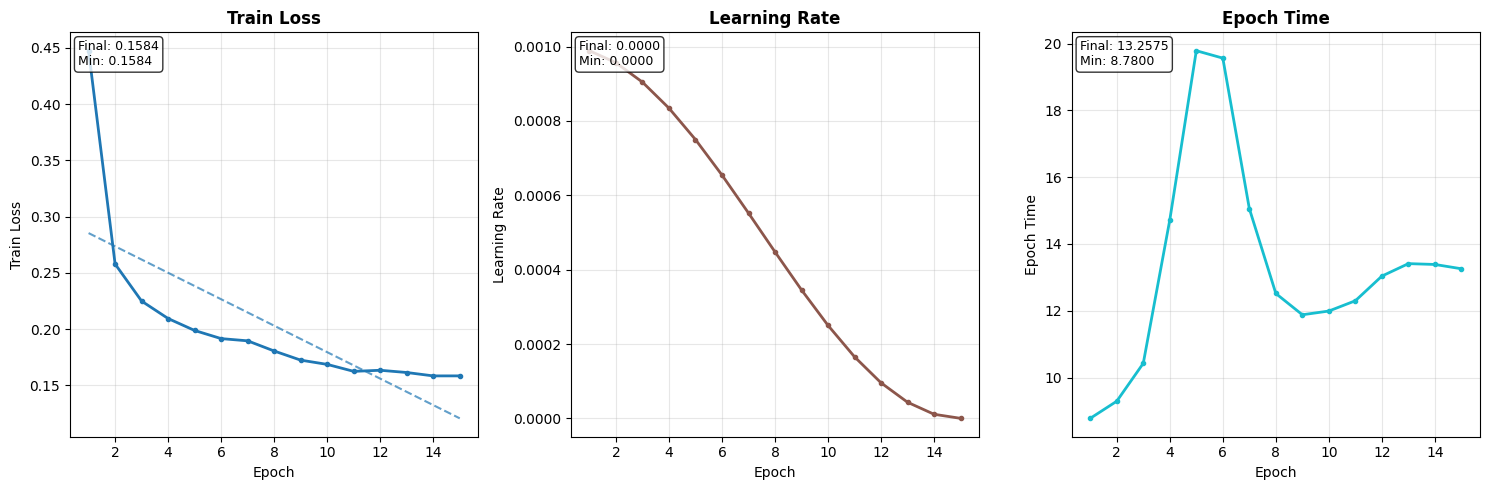

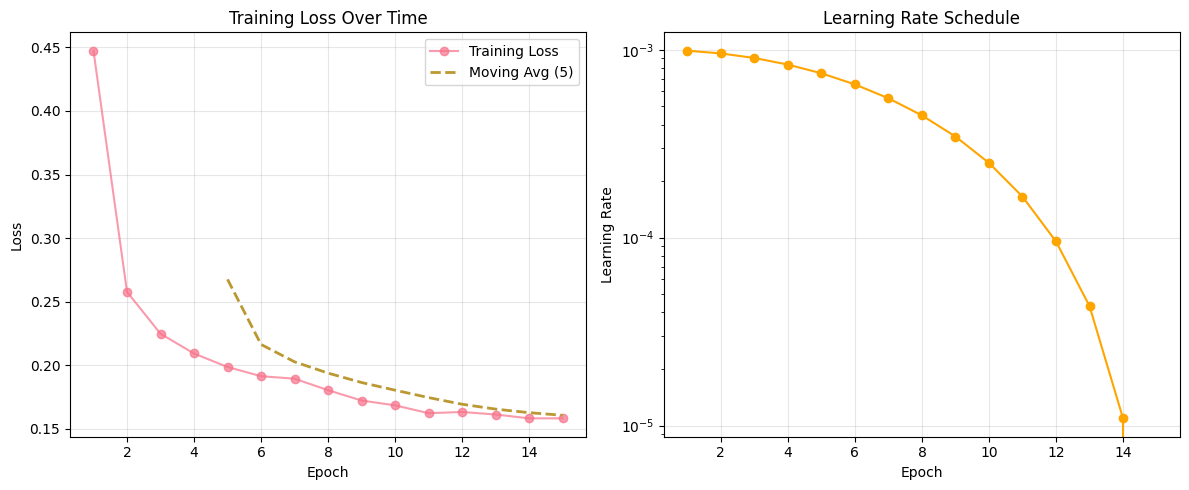

Final training loss: 0.158379
Best training loss: 0.158372
Total training time: 199.4s


In [16]:
# Visualize training metrics

# Plot training metrics using your utility function
plot_training_metrics(training_metrics, figsize=(15, 5))

# Additional analysis
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Loss trend with moving average
epochs = range(1, len(training_metrics['train_loss']) + 1)
losses = training_metrics['train_loss']

axes[0].plot(epochs, losses, 'o-', alpha=0.7, label='Training Loss')
if len(losses) > 5:
    # Moving average for trend
    window = min(5, len(losses) // 3)
    moving_avg = pd.Series(losses).rolling(window=window).mean()
    axes[0].plot(epochs, moving_avg, '--', linewidth=2, label=f'Moving Avg ({window})')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate schedule
axes[1].plot(epochs, training_metrics['learning_rate'], 'o-', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training loss: {training_metrics['train_loss'][-1]:.6f}")
print(f"Best training loss: {min(training_metrics['train_loss']):.6f}")
print(f"Total training time: {sum(training_metrics['epoch_time']):.1f}s")

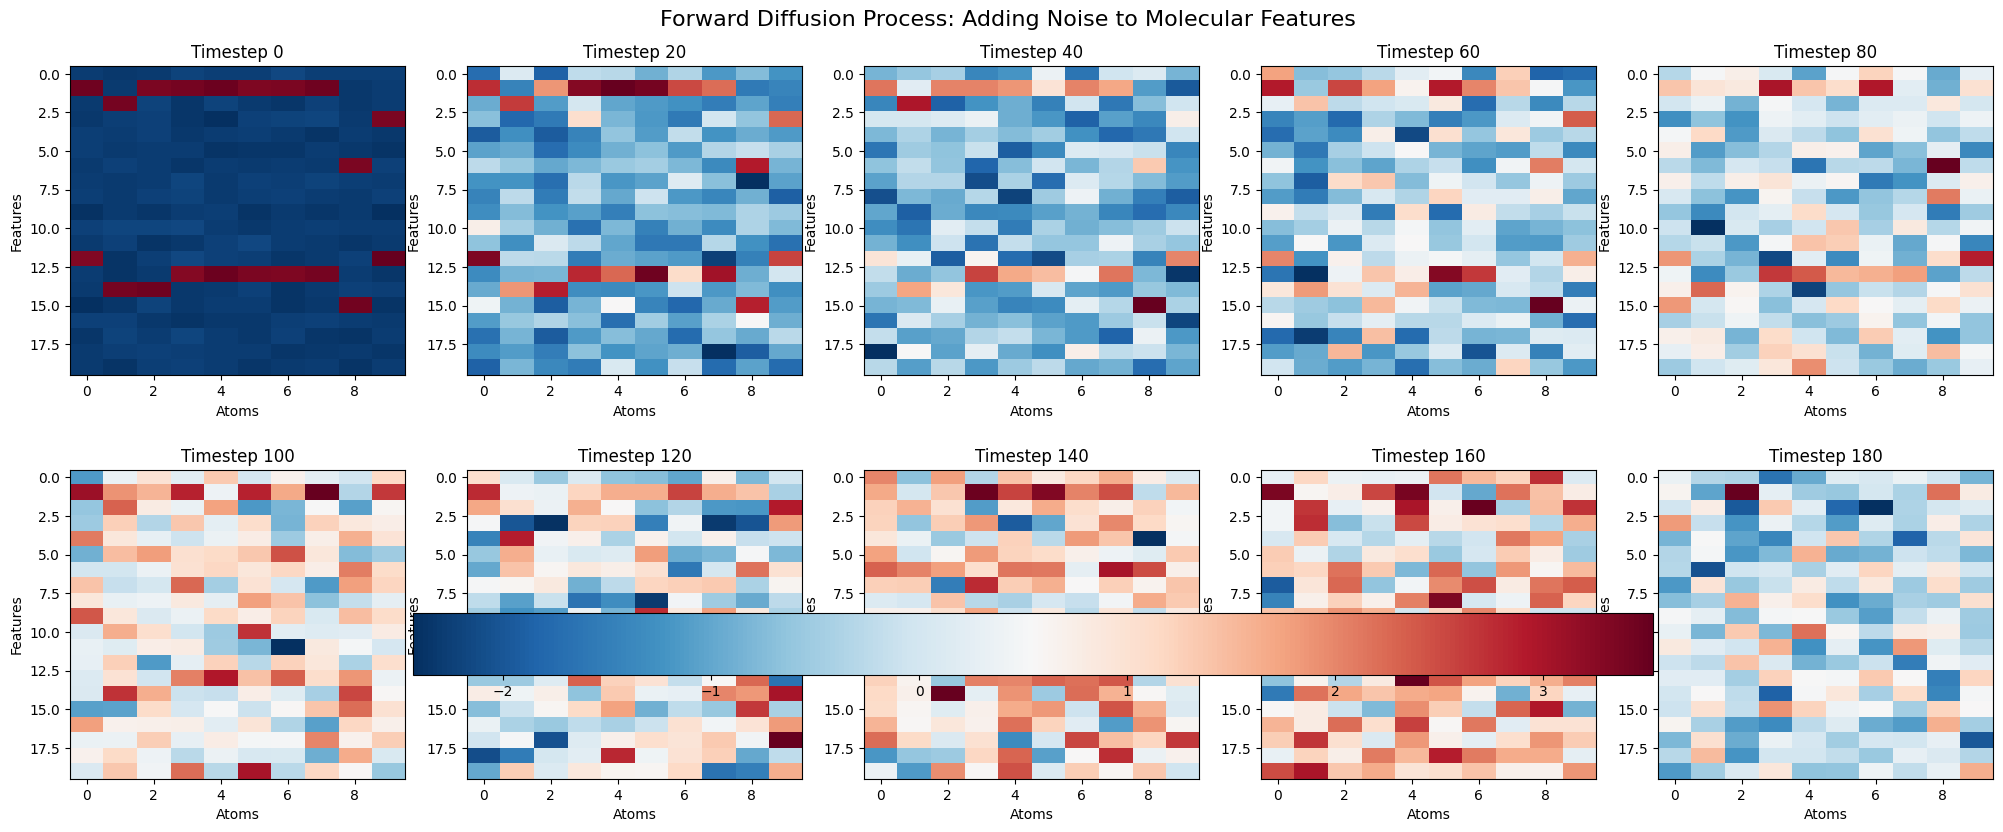

In [19]:
def visualize_diffusion_process(model, scheduler, dataloader, device, num_timesteps=10):
    """Visualize how noise is added and removed during diffusion"""

    model.eval()
    with torch.no_grad():
        # Get a sample batch
        for batch in dataloader:
            batch = batch.to(device)
            break

        # Take first molecule from batch
        mol_mask = (batch.batch == 0)
        original_features = batch.x[mol_mask]

        # Show forward process (adding noise)
        timesteps_to_show = list(range(0, scheduler.num_timesteps, scheduler.num_timesteps // num_timesteps))[:num_timesteps]

        noisy_samples = []
        for t in timesteps_to_show:
            # Create timestep tensor
            t_tensor = torch.tensor([t], device=device, dtype=torch.long)
            noisy = scheduler.add_noise(original_features, t_tensor.repeat(original_features.shape[0]))

            # Store sample
            try:
                noisy_samples.append(noisy.cpu().numpy())
            except:
                # Fallback if numpy conversion fails
                noisy_samples.append(noisy.cpu().tolist())

        # Visualize feature evolution
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()

        for i, (t, noisy_sample) in enumerate(zip(timesteps_to_show, noisy_samples)):
            # Handle both numpy arrays and lists
            if isinstance(noisy_sample, list):
                # Convert list to numpy for visualization
                noisy_sample = np.array(noisy_sample)

            # Show first few features as heatmap
            sample_features = noisy_sample[:min(10, noisy_sample.shape[0]), :min(20, noisy_sample.shape[1])]

            im = axes[i].imshow(sample_features.T, cmap='RdBu_r', aspect='auto')
            axes[i].set_title(f'Timestep {t}')
            axes[i].set_xlabel('Atoms')
            axes[i].set_ylabel('Features')

        # Add colorbar
        plt.colorbar(im, ax=axes, orientation='horizontal', pad=0.1, shrink=0.8)
        plt.suptitle('Forward Diffusion Process: Adding Noise to Molecular Features', fontsize=16)
        plt.tight_layout()
        plt.show()

        return original_features, noisy_samples

# Visualize the diffusion process
original_features, noisy_evolution = visualize_diffusion_process(best_model, noise_scheduler, dataloader, device=device)

In [20]:
# Molecular property prediction

# Create GNN backbone for property prediction
property_gnn = create_molecular_gnn(
    atom_dim=atom_dim,
    bond_dim=bond_dim,
    hidden_dim=64,
    num_layers=2,
    gnn_type='gat'
).to(device)

# Train a property predictor for validation
property_predictor = MolecularPropertyPredictor(
    gnn=property_gnn,
    num_tasks=3  # Predict 3 molecular properties
).to(device)

def create_property_targets(dataloader, max_batches=50):
    """Create property prediction targets from SMILES"""
    all_features = []
    all_targets = []
    all_batches = []

    for i, batch in enumerate(dataloader):
        if i >= max_batches:
            break

        batch_size = batch.batch.max().item() + 1
        targets = []

        # Extract SMILES for this batch (simplified - you'd need proper mapping)
        for mol_idx in range(batch_size):
            # Dummy properties for demonstration
            mol_weight = np.random.normal(300, 100)  # Molecular weight
            logp = np.random.normal(2, 1)           # LogP
            num_rings = np.random.poisson(2)        # Number of rings

            targets.append([mol_weight, logp, num_rings])

        all_features.append(batch)
        all_targets.append(torch.tensor(targets, dtype=torch.float32))
        all_batches.append(i)

    return all_features, all_targets

# This is a simplified version - in practice you'd extract real properties
print("Creating property prediction dataset...")
feature_batches, target_batches = create_property_targets(dataloader)

print(f"Created property dataset with {len(feature_batches)} batches")
print("Note: This uses dummy targets - real implementation would extract properties from SMILES")

Creating property prediction dataset...
Created property dataset with 50 batches
Note: This uses dummy targets - real implementation would extract properties from SMILES


Model Quality Analysis:
Average loss: 0.097532
Loss std: 0.042051

Noise Prediction Quality by Timestep:
  t= 10: MSE = 0.483553
  t= 50: MSE = 0.077891
  t=100: MSE = 0.052959
  t=150: MSE = 0.044675


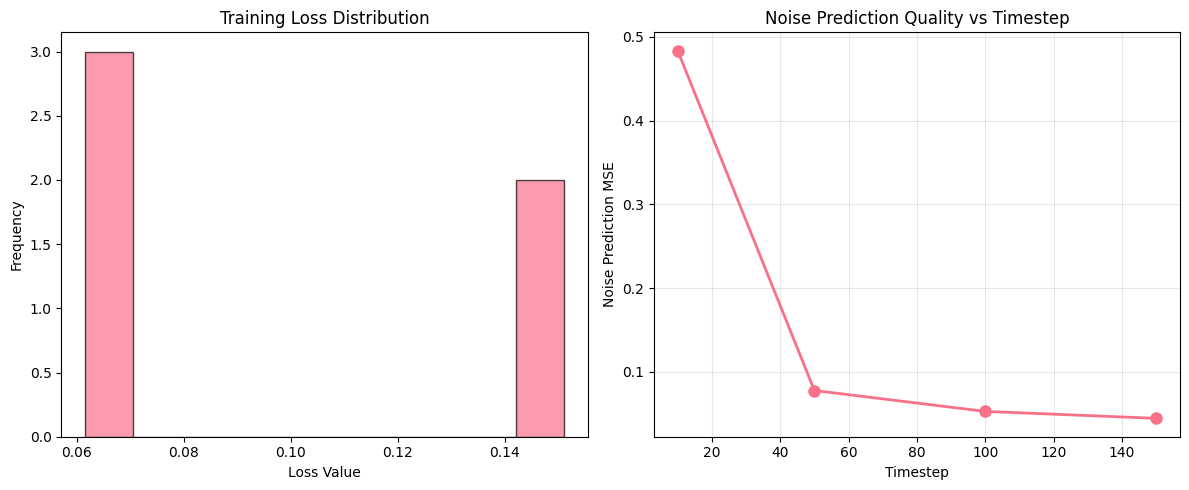

In [21]:
def analyze_model_quality(model, scheduler, dataloader, device, num_samples=5):
    """Analyze the quality of the trained diffusion model"""

    model.eval()
    analysis_results = {
        'loss_distribution': [],
        'noise_prediction_quality': [],
        'feature_statistics': {}
    }

    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break

            batch = batch.to(device)
            batch_size = batch.batch.max().item() + 1

            # Compute loss
            t = torch.randint(0, scheduler.num_timesteps, (batch_size,), device=device)
            noise = torch.randn_like(batch.x)
            x_noisy = scheduler.add_noise(batch.x, t[batch.batch], noise)
            noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)
            loss = torch.nn.functional.mse_loss(noise_pred, noise)
            analysis_results['loss_distribution'].append(loss.item())

            # Test noise prediction at different timesteps
            for t_val in [10, 50, 100, 150]:
                if t_val < scheduler.num_timesteps:
                    t = torch.full((batch_size,), t_val, device=device)

                    # Add known noise
                    noise_true = torch.randn_like(batch.x)
                    x_noisy = scheduler.add_noise(batch.x, t[batch.batch], noise_true)

                    # Predict noise
                    noise_pred = model(x_noisy, batch.edge_index, batch.edge_attr, batch.batch, t)

                    # Measure prediction quality
                    mse = torch.mean((noise_pred - noise_true) ** 2).item()
                    analysis_results['noise_prediction_quality'].append((t_val, mse))

    # Analyze results
    print("Model Quality Analysis:")
    print("=" * 40)
    print(f"Average loss: {np.mean(analysis_results['loss_distribution']):.6f}")
    print(f"Loss std: {np.std(analysis_results['loss_distribution']):.6f}")

    # Group noise prediction by timestep
    timestep_analysis = defaultdict(list)
    for t_val, mse in analysis_results['noise_prediction_quality']:
        timestep_analysis[t_val].append(mse)

    print("\nNoise Prediction Quality by Timestep:")
    for t_val in sorted(timestep_analysis.keys()):
        avg_mse = np.mean(timestep_analysis[t_val])
        print(f"  t={t_val:3d}: MSE = {avg_mse:.6f}")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss distribution
    axes[0].hist(analysis_results['loss_distribution'], bins=10, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Loss Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Training Loss Distribution')

    # Noise prediction by timestep
    timesteps = sorted(timestep_analysis.keys())
    avg_mses = [np.mean(timestep_analysis[t]) for t in timesteps]

    axes[1].plot(timesteps, avg_mses, 'o-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Timestep')
    axes[1].set_ylabel('Noise Prediction MSE')
    axes[1].set_title('Noise Prediction Quality vs Timestep')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Analyze model quality
analyze_model_quality(best_model, noise_scheduler, dataloader, device)


## Next Steps

    "1. GENERATION PIPELINE",
    "   - Implement complete sampling from pure noise",
    "   - Add graph structure generation (edges, connectivity)",
    "   - Convert generated features back to SMILES strings",

    "2. VALIDATION FRAMEWORK",
    "   - Train property predictors on real molecular properties",
    "   - Implement validity checking (RDKit molecule validation)",
    "   - Add novelty and uniqueness metrics",

    "3. ADVANCED ARCHITECTURES",
    "   - Implement full MolDiff with explicit bond modeling",
    "   - Add E(3)-equivariant networks for 3D coordinates",
    "   - Experiment with different noise schedules (cosine, sigmoid)",

    "4. DEEPCHEM INTEGRATION",
    "   - Create TorchModel wrapper for DeepChem compatibility",
    "   - Add proper fit(), predict(), evaluate() methods",
    "   - Integrate with DeepChem's evaluation framework",

    "5. SCALING AND OPTIMIZATION",
    "   - Test on larger datasets (ZINC15, ChEMBL)",
    "   - Implement gradient checkpointing for memory efficiency",
    "   - Add multi-GPU training support"
